## This version Simulates IA on a Logrithmic Scale
#### Features
- General density and angular distributions are enabled
- Density Profile Tracking enabled
- Different built-in sampling methods enabled

#### Deprecation
- R_cut deprecated: everything radial should be normalized before input
- 3D-catalogue-building(All_Sats) deprecated
- All_Sats_2D deprecated, merged into the vector Proj_Data to conserve disk space

#### run_folder name standard (the master folder of each condition's run is called outputpath):
- 'mod n n baR baR smr smr' etc... the second instance is the actual number. seperated by nothing but space

### Modules generated by respectively named jupyter notebooks

### Main Function:

In [34]:
%%writefile ia_main.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
import sys
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *

###############################################################################################################
########                     This block contains Setups for this simulation                            ########
########                     Scroll to the end of file to code executions                              ########
########                     Check for Rank-Dependence before running                                  ########
###############################################################################################################
#
def baR_func(x,y,z,global_r,global_theta,global_phi): 
    return baR_0#+np.random.normal(0,0) #b/a ratio has an 

def theta_func(x,y,z,global_r,global_theta,global_phi,std): 
    #### GAUSSIAN NOISE
    return global_theta+np.random.normal(0,std) #(center, std)

def phi_func(x,y,z,global_r,global_theta,global_phi,std): 
    #### GAUSSIAN NOISE
    return global_phi+np.random.normal(0,std)

def density_func(x,y,z,global_r,global_theta,global_phi): #NEED TO BE NORMALIZED
    # this gives the Fraction NUMBER of gals expected in a box of size dV, approximated at (x,y,z)
    # should normalize to 1, but given the finiteness of n,  this only holds as n gets large
    if (global_r > 1): return 0
    else: 
        #return 1/(4*np.pi/3)
        return 1/((global_r*concentration)*(1+global_r*concentration)**2)

###############################################################################################################
########                     This block contains the core functions for this simulation                ########
########                               Check for Rank-Dependence before running                        ########
###############################################################################################################

def get_RA_data(save_2D,iteration_tracker,outputpath,mode,n,baR_0,phistd,thetastd): 
    import sys
    #n=64 ~ 1min30sec
    
    #x,y,z are of size 2n+1, {+1,-1, and 0 always included to prevent singularities in functions}
    if mode == 'linear':
        xs = get_axis_lin(n)
        ys = get_axis_lin(n)
        zs = get_axis_lin(n)
    if mode == 'linear_cut': #To be implemented
        xs = None
        ys = None
        zs = None
        sys.exit('code not ready')
    if mode == 'log':
        xs = get_axis_log(n)
        ys = get_axis_log(n)
        zs = get_axis_log(n)
    
    #get a list of mid points and cell widths for later computing values in each simulated cell
    midx = get_mid_points(xs)
    midy = get_mid_points(ys)
    midz = get_mid_points(zs)
    diffx = get_diff_list(xs)
    diffy = get_diff_list(ys)
    diffz = get_diff_list(zs)
    #print(xs)
    #print(midx)
    #print(diffx)
    
    #this prevents the density function later used become to small for numeric purposes
    #this will get divided out later. doesnt really matter
    total_number_of_sats = (2*n)**3
    
    #[[x_cell_midpt, y_cell_midpt, r , sum_eps+(midpt)_at_xy, sum_numberfraction(midpt)_at_xy]]
    #This will be saved in file. # x, y are only used to plot the 2D density profile. Otherwise, r is enough
    Proj_Data=np.empty((0,5))
    
    for x_index in range(2*n):
        #looping in range2*n ensures never out of bound
        #midpoint_cell_coordinate will be referred to as = x,y,z.
        x = midx[x_index]
        dx = diffx[x_index]
        
        for y_index in range(2*n):
            y = midy[y_index]
            dy = diffy[y_index]
            
            [[global_r,global_phi]] = Cart_to_Polar(np.array([[x,y]]))
            weighted_orients_same_r = np.zeros(2) #stores np.array: [sum_of_weighted_epsilon+_at_r, sum_of_rho_at_r]
            #print(x,y,global_r)
            for z_index in range(2*n):
                z = midz[z_index]
                dV=dx*dy*diffz[z_index]
                #print(dV)
                
                #global here refers to global coordinates
                #local meanning local to the cell, evaluated at cell midpt
                #[[global_r,global_theta,global_phi]] = Cart_to_Sph(np.array([[x,y,z]]))   #get sat's position in global sph coord
                global_theta = RZ_to_Theta(np.array([[global_r,z]]))
                #each function will decide if (xyz) or (r,theta, phi) is faster
                #other parameters are defined globally before this function is run
                local_num_fraction = density_func(x,y,z,global_r,global_theta,global_phi)*dV*total_number_of_sats    #density * volume
                local_baR          = baR_func(x,y,z,global_r,global_theta,global_phi)
                local_theta        = theta_func(x,y,z,global_r,global_theta,global_phi,thetastd)
                local_phi          = phi_func(x,y,z,global_r,global_theta,global_phi,phistd)
                
                #get sat's orientation (see nnote below!!!) in local sph and cartesian coord. #not very useful, deactivated.
                #But IMPORTANT to note that
                #This vector IS NOT WHAT SATELLITEs PHYSICALLY LOOKLIKE. R direction encodes b/a Ratio. 
                #But this vector physically parallels the satellite's shape
                #local_baR_vector = np.array([[local_baR,local_theta,local_phi]]) 
                #[[local_x,local_y,local_z]] = Sph_to_Cart(local_baR_vector)

                #Deprecated #build 2D projected catalogue with average baR
                proj_mag = Ellip_proj_mag(local_baR,local_theta)    #calculate the projected b/a Ratio first
                #print('ptoeps',Polar_to_eps(global_phi,proj_mag,local_phi))
                #print(local_num_fraction)
                weighted_orients_same_r[0]+=Polar_to_eps(global_phi,proj_mag,local_phi)*local_num_fraction #sum over z
                weighted_orients_same_r[1]+=local_num_fraction
                #print(weighted_orients_same_r)
            Proj_Data = np.vstack((Proj_Data,np.array([
                                   x,
                                   y,
                                   global_r,
                                   weighted_orients_same_r[0],
                                   weighted_orients_same_r[1]])))
                
                 #This whole section is removed in favor of a the above more efficient code (and the algorithm has changed to reflect the logic of true observations)
                
#                #Deprecated #[[proj_local_x, proj_local_y]]=Polar_to_Cart(np.array([[proj_mag,local_phi]]))    #convert the projected vector to cartesian
#                #Deprecated #weighted_orients_same_xy = np.append(weighted_orients_same_xy,[[proj_local_x*local_num_fraction,proj_local_y*local_num_fraction,local_num_fraction]],axis=0)
#
#            #Deprecated #compute the average baR vector. add all orient vectors of the same x,y coord element-wise
#            #Deprecated #sum_temp = np.sum(weighted_orients_same_xy,axis=0)
#
#            if (np.abs(sum_temp[2])) >= 10.**(-13):# if the density is 0, can just set the mean vector to 0, this also avoids 0 division
#               [mean_temp_x,mean_temp_y] = sum_temp[0:2]/sum_temp[2]
#               sum_temp[2]=sum_temp[2]/total_number_of_sats #this gets rid of the run-dependent factor that helped with the previous calculations
#                
#                #Deprecated! All_Sats_2D = np.append(All_Sats_2D,[[x,y,mean_temp_x,mean_temp_y,sum_temp[2]]],axis=0)
#                
#                #from the average baR vector, compute the expected gamma+ value at (x,y)
#                Proj_Data = np.append(Proj_Data,np.array([[
#                                                                        x,
#                                                                        y,
#                                                                        Cart_to_eps(np.array([[x,y,mean_temp_x,mean_temp_y]])),
#                                                                        sum_temp[2],
#                                                                        mean_temp_x,
#                                                                        mean_temp_y,
#                                                                        ]]),axis=0)
    
    #Now reduce the 2D data to 1D: perform radial averaging and get the gamma+ function
    #get the radial axis from 0 to 1, this has size n+1. Will later take the number of intervals, 
    #and will thus reduce the size of radial axis to n
    if mode == 'linear':
        rs = get_axis_lin(n)[n:2*n+1]
    if mode == 'linear_cut': #To be implemented
        rs = None
        sys.exit('code not ready')
    if mode == 'log':
        rs = get_axis_log(n)[n:2*n+1]
    
    gamma_plus = np.zeros(n) #size=n
    densities = np.zeros(n)
    #print(Proj_Data[:,3])
    #print(Proj_Data[:,4])
    #Will store densities and rs seperately #R_density_profile = np.empty((0,n)) #stores[[Radial coord],densities]
    for i in range(n): # n = len(rs)-1. i.e. there is nothing beyond R_cut
        #each i is a radial interval
        #print(rs[i])
        count=0
        #print(Proj_Data)
        for elmt in Proj_Data:
            #print(elmt)
            # if in the first, second, third, radial interval(s)... and so on.
            xyplane_dist = elmt[2]
            if (xyplane_dist >= rs[i] and xyplane_dist < rs[i+1]):
                gamma_plus[i] += elmt[3]
                count += elmt[4] #adds up the total number density, in case it is 0, and cannot be used to average Gamma+
        #print(gamma_plus[i],count)
        if (count == 0):
            gamma_plus[i]=0
        else: gamma_plus[i]=gamma_plus[i]/count
        densities[i] = count/((rs[i+1]-rs[i])*2*np.pi*((rs[i+1]+rs[i])/2)) #number/area(i.e. the ring)
    rs = get_mid_points(rs)
    
    densities2D = np.vstack((Proj_Data[:,0],Proj_Data[:,1],Proj_Data[:,4]))
#    This section is killed in favor of the above more efficient one: In General_Condition_IA_Sim_v5_3DDirectComputation    
#    for i in range(n): # n = len(rs)-1. i.e. there is nothing beyond R_cut
#        #each i is a radial interval
#        count=0
#        for elmt in Proj_Data:
#            # if in the first, second, third, radial interval(s)... and so on.
#            xyplane_dist = np.sqrt(elmt[0]**2+elmt[1]**2)
#            if (xyplane_dist >= rs[i] and xyplane_dist < rs[i+1]):
#                gamma_plus[i] += elmt[2]*elmt[3]
#                count += elmt[3] #adds up the total number density, in case it is 0, and cannot be used to average Gamma+
#        if (count == 0):
#            gamma_plus[i]=0
#        else: gamma_plus[i]=gamma_plus[i]/count
#        densities[i] = count
                

    
    #R_density_profile = np.vstack((R_density_profile,densities))
    #R_density_profile = np.vstack((R_density_profile,rs))
                
    if save_2D == True:
        if iteration_tracker == 0: #only save rs once for a setting
            write_file_at_path(outputpath, 'NA', rs,'rs'+mode+'mod')
        #write_file_at_path(outputpath, 'proj_data', Proj_Data,str(iteration_tracker)+mode+'mod')
        write_file_at_path(outputpath, 'gamma_plus', gamma_plus,str(iteration_tracker)+mode+'mod')
        write_file_at_path(outputpath, 'densities', densities,str(iteration_tracker)+mode+'mod')
        write_file_at_path(outputpath, 'densities2D', densities2D,str(iteration_tracker)+mode+'mod')

n=64
baR_0 = 0.2
concentration = 20 #R_virial = Rs*c. since R_virial is usually chosen as the cut of limit for density profiles, we set it to 1.

smr_run = np.pi/4
run_folder = 'NFW n %i baR_0 %1.2f smr %1.2f'%(n,0.2,rad_to_deg(smr_run))
offset = 0
size_per_rank = 3

def run_rank_sing_cond(node_index,batch_num,offset): 
    if rank == node_index:
        if batch_num == 0:
            for i in range(size_per_rank):
                get_RA_data(True,i+(size_per_rank*(rank-1)),outputpath,'linear',n,baR_0,smr_run,smr_run)
        if batch_num == 1:
            for i in range(size_per_rank):
                get_RA_data(True,i+(size_per_rank*(rank-7)),outputpath,'log',n,baR_0,smr_run,smr_run)

                
outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output'
outputpath = os.path.join(outputpath,run_folder)


#how ever many slot you want to run:
run_rank_sing_cond(0,0,offset)
run_rank_sing_cond(1,0,offset)
run_rank_sing_cond(2,0,offset)
run_rank_sing_cond(3,0,offset)
run_rank_sing_cond(4,0,offset)
run_rank_sing_cond(5,0,offset)
run_rank_sing_cond(6,0,offset)
time.sleep(5) #this gives time for the previous threads to create directories, etcs.
run_rank_sing_cond(7,1,offset)
run_rank_sing_cond(8,1,offset)
run_rank_sing_cond(9,1,offset)
run_rank_sing_cond(10,1,offset)
run_rank_sing_cond(11,1,offset)
run_rank_sing_cond(12,1,offset)
run_rank_sing_cond(13,1,offset)
run_rank_sing_cond(14,1,offset)

Overwriting ia_main.py


[2.83547830e+11 6.01635390e+10 2.41324471e+10 1.23814620e+10
 7.26672535e+09 4.64990812e+09 3.16220731e+09 2.25052026e+09
 1.65935042e+09 1.25866900e+09 9.77224901e+08 7.73622592e+08
 6.22639109e+08 5.08284899e+08 4.20078386e+08 3.50948217e+08
 2.96003140e+08 2.51784982e+08 2.15800954e+08 1.86222852e+08
 1.61688942e+08 1.41170654e+08 1.23881147e+08 1.09211495e+08
 9.66854416e+07 8.59268467e+07 7.66359641e+07 6.85719305e+07
 6.15396993e+07 5.53801870e+07 4.99627687e+07 4.51795123e+07
 4.09407086e+07 3.71713811e+07 3.38085377e+07 3.07989933e+07
 2.80976320e+07 2.56660120e+07 2.34712388e+07 2.14850498e+07
 1.96830664e+07 1.80441801e+07 1.65500456e+07 1.51846604e+07
 1.39340138e+07 1.27857927e+07 1.17291330e+07 1.07544084e+07
 9.85304921e+06 9.01738414e+06 8.24050124e+06 7.51612097e+06
 6.83847686e+06 6.20219652e+06 5.60217386e+06 5.03341797e+06
 4.49085327e+06 3.96902181e+06 3.46158267e+06 2.96035399e+06
 2.45317857e+06 1.91804475e+06 1.29965817e+06 0.00000000e+00]


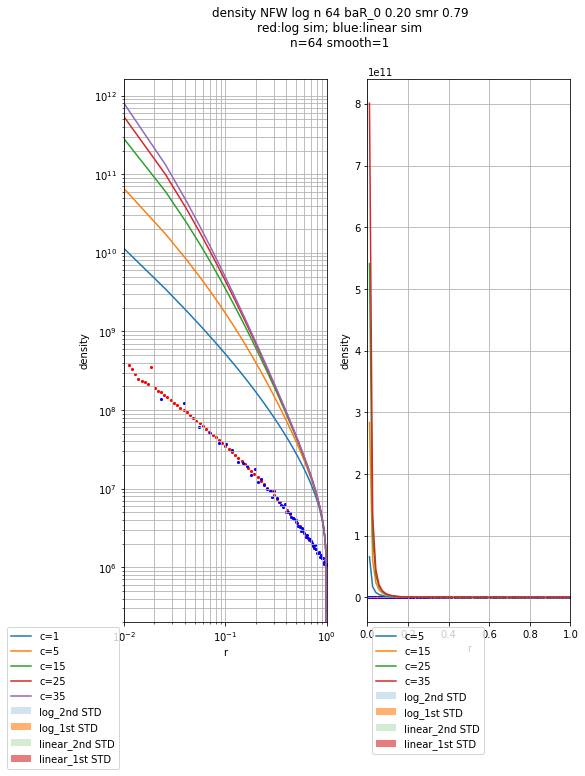

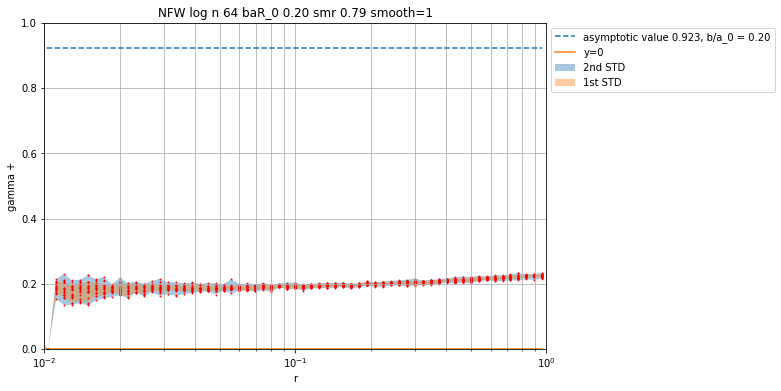

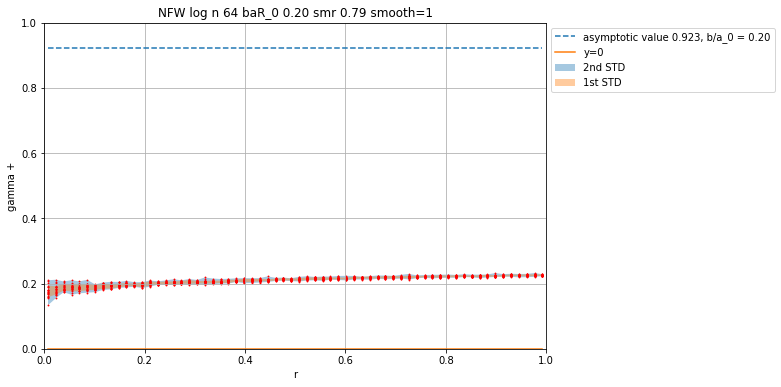

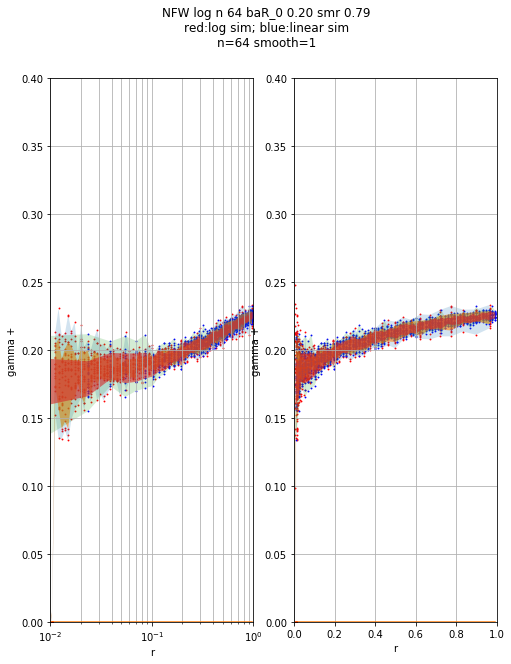

In [60]:
from plot_func import *
import sys
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *

n=64
baR_0 = 0.2
concentration = 20 #R_virial = Rs*c. since R_virial is usually chosen as the cut of limit for density profiles, we set it to 1.

run_folder = 'NFW log n 64 baR_0 0.20 smr 0.79'

outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output'
outputpath = os.path.join(outputpath,run_folder)


#gamma_base_plot(1,outputpath,'line')
density_plot(1,run_folder)
error_bar_plot(1,run_folder)


In [59]:
def density_plot(smoothing_len,run_folder): 
    
    import sys
    import os
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import execution_func as ef
    import re
    
    def integrateNFW(r,c,N):
        a=np.sqrt(1-r**2)
        z = np.linspace(-a, a, N)
        tempv = np.sqrt(r**2+z**2)
        #fz = 2*np.pi/(tempv*c*(1+c*tempv)**2)
        fz = 2*np.pi/(tempv*c*(1+c*tempv)**2)
        area = np.sum(fz)*2*a/N
        return area
    
    outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output'
    outputpath = os.path.join(outputpath,run_folder)
    
    searchpath = os.path.join(outputpath,'densities')
    path_bar_search = re.search('baR_0 ([+-]?([0-9]*[.])?[0-9]+)', outputpath, re.IGNORECASE)
    baR_0 = float(path_bar_search.group(1))
    
    #check which plots are possible to make
    LOGSIMFLAG = False
    LINEARSIMFLAG = False
    HYBRIDFLAG = False
    SINGLEPLOTFLAG = True #if we have both log and lin, then just plot the hybrid
    if os.path.isfile(os.path.join(outputpath,'rslogmod')):
        LOGSIMFLAG = True
    if os.path.isfile(os.path.join(outputpath,'rslinearmod')):
        LINEARSIMFLAG = True
    if (LOGSIMFLAG == True and LINEARSIMFLAG == True): 
        HYBRIDFLAG = True
        SINGLEPLOTFLAG = False
    if (LOGSIMFLAG == False and LINEARSIMFLAG == False): sys.exit(['no radial coordinate file detected'])
    
    #consistency checks:
    #1. the linear and log rs should have the same length. this should agree with the n number in the output path
        #the rs file we grab from the run_folder has length n by construction
    #2. the smoothing length needs to be a factor of n
    path_n_search = re.search('n (\d+)', outputpath, re.IGNORECASE)
    n = int(path_n_search.group(1))
    if LOGSIMFLAG == True:
        rs_presmoothlog=ef.read_file_from_name(outputpath,'rslogmod')
        if (n != len(rs_presmoothlog)):
            sys.exit(['error(s) in log radial vector(s)!!!'])
    if LINEARSIMFLAG == True:
        rs_presmoothlinear=ef.read_file_from_name(outputpath,'rslinearmod')
        if (n != len(rs_presmoothlinear)):
            sys.exit(['error(s) in linear radial vector(s)!!!'])
    if HYBRIDFLAG == True:
        if ((n != len(rs_presmoothlog)) or (n != len(rs_presmoothlinear)) or (len(rs_presmoothlog)!= len(rs_presmoothlinear))):
            sys.exit(['in consistencies among radial vector(s)!!!'])
    if (n%smoothing_len != 0):
        sys.exit(['incompatible smoothing length!!!(smoothing length needs to be a factor of n)'])
    
    #reference curves setups
    ref_r = np.linspace(0.01,1,n)
    def get_ref_density(conc):
        arr_c = np.array([]) #plotted only in linear for simplicity, since this is just a reference curve
        #totalmass = 4.0*np.pi*(1**3)*(np.log(1+conc)+conc/(1+conc))#with max radial coordinate normalized to 1
        for i in range(int(n/smoothing_len)):
            radius = ref_r[i]
            if (radius > 1): arr_c=np.append(arr_c,0)
            else: 
                #return 1/(4*np.pi/3)
                temp_=integrateNFW(radius,conc,100)
                #temp_ = 4*np.pi*(radius)/(radius*conc*(1+radius*conc)**2)# the r accounts for the projected 2d NFW profile, up to constant multiple
                arr_c=np.append(arr_c,temp_)
        #print(arr_c)
        return arr_c
    
    #LOG PLOT:
    if LOGSIMFLAG == True:
        rs_log = np.array([sum(rs_presmoothlog[i:i+smoothing_len])/smoothing_len for i in range(0,len(rs_presmoothlog),smoothing_len)])   
        #get all the log files
        gamma_log = np.empty((0,int(n/smoothing_len)))
        for i in os.listdir(searchpath):
            if i.endswith("logmod"):
                if os.path.isfile(os.path.join(searchpath, i)): #check if it is file and not directory
                    temp_gam = ef.read_file_from_name(searchpath,i)
                    temp_gam_smoothed = np.array([sum(temp_gam[i:i+smoothing_len])/smoothing_len for i in range(0,len(temp_gam),smoothing_len)])   
                    gamma_log = np.vstack((gamma_log,temp_gam_smoothed))
        error_GamPls_log = ef.sort_matrix_columns(gamma_log)
        #print(complete_GamPls)
        error_GamPls_log = ef.get_1_2_std(error_GamPls_log)
        #print(complete_GamPls)
        error_GamPls_log = np.vstack((error_GamPls_log,rs_log)) #attach the smoothed x coordinate
        
        maxR_density_ref = (error_GamPls_log[0,-2]+error_GamPls_log[1,-2])/2 
        #this is used to construnct the normalized reference curve so they will agree at the end
        c1 = get_ref_density(1)
        c1 = c1*maxR_density_ref/c1[-2]
        c5 = get_ref_density(5)
        c5 = c5*maxR_density_ref/c5[-2]
        c15 = get_ref_density(15)
        c15 = c15*maxR_density_ref/c15[-2]
        c25 = get_ref_density(25)
        c25 = c25*maxR_density_ref/c25[-2]
        c35 = get_ref_density(35)
        c35 = c35*maxR_density_ref/c35[-2]
        
        if SINGLEPLOTFLAG:
            #plot:
            fig1 = plt.figure(figsize=(9,6))
            plt.fill_between(rs_log,error_GamPls_log[2],error_GamPls_log[3],alpha = 0.4,label='2nd STD')    
            plt.fill_between(rs_log,error_GamPls_log[0],error_GamPls_log[1],alpha = 0.4,label='1st STD')
            for g in gamma_log:
                plt.scatter(rs_log,g,c='r',s=0.75,marker='o')        
            plt.plot(ref_r,c5,label='c=1')
            plt.plot(ref_r,c5,label='c=5')
            plt.plot(ref_r,c15,label='c=15')
            plt.plot(ref_r,c25,label='c=25')
            plt.plot(ref_r,c35,label='c=35')
            plt.xscale('log')
            plt.xlabel('r')
            plt.ylabel('density')
            plt.grid(b=True,which='both')
            plt.title('density'+run_folder+' smooth=%i'% int(smoothing_len))
            plt.xlim(0.01,1)
            #plt.ylim(0,1)
            plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
            imagesavepath = os.path.join(outputpath, 'figures')
            if not os.path.exists(imagesavepath):
                os.makedirs(imagesavepath)
            fig1.savefig(os.path.join(imagesavepath, 'STD density '+str(n)+' smth %i log'%smoothing_len), bbox_inches = 'tight')

    #LINEAR PLOT:
    if LINEARSIMFLAG == True:
        rs_linear = np.array([sum(rs_presmoothlinear[i:i+smoothing_len])/smoothing_len for i in range(0,len(rs_presmoothlinear),smoothing_len)])   
        #get all the log files
        gamma_linear = np.empty((0,int(n/smoothing_len)))
        for i in os.listdir(searchpath):
            if i.endswith("linearmod"):
                if os.path.isfile(os.path.join(searchpath, i)): #check if it is file and not directory
                    temp_gam = ef.read_file_from_name(searchpath,i)
                    temp_gam_smoothed = np.array([sum(temp_gam[i:i+smoothing_len])/smoothing_len for i in range(0,len(temp_gam),smoothing_len)])   
                    gamma_linear = np.vstack((gamma_linear,temp_gam_smoothed))
        error_GamPls_linear = ef.sort_matrix_columns(gamma_linear)
        #print(complete_GamPls)
        error_GamPls_linear = ef.get_1_2_std(error_GamPls_linear)
        #print(complete_GamPls)
        error_GamPls_linear = np.vstack((error_GamPls_linear,rs_linear)) #attach the smoothed x coordinate
        
        maxR_density_ref = (error_GamPls_log[0,-2]+error_GamPls_log[1,-2])/2 
        c1 = get_ref_density(1)
        c1 = c1*maxR_density_ref/c1[-2]
        c5 = get_ref_density(5)
        c5 = c5*maxR_density_ref/c5[-2]
        c15 = get_ref_density(15)
        c15 = c15*maxR_density_ref/c15[-2]
        c25 = get_ref_density(25)
        c25 = c25*maxR_density_ref/c25[-2]
        c35 = get_ref_density(35)
        c35 = c35*maxR_density_ref/c35[-2]
        #print(c25[-1],maxR_density_ref)
        if SINGLEPLOTFLAG:
            #plot:
            fig2 = plt.figure(figsize=(9,6))
            plt.fill_between(rs_linear,error_GamPls_linear[2],error_GamPls_linear[3],alpha = 0.4,label='2nd STD')    
            plt.fill_between(rs_linear,error_GamPls_linear[0],error_GamPls_linear[1],alpha = 0.4,label='1st STD')
            for g in gamma_linear:
                plt.scatter(rs_linear,g,c='r',s=0.75,marker='o')        
            plt.plot(ref_r,c1,label='c=1')
            plt.plot(ref_r,c5,label='c=5')
            plt.plot(ref_r,c15,label='c=15')
            plt.plot(ref_r,c25,label='c=25')
            plt.plot(ref_r,c35,label='c=35')
            plt.xlabel('r')
            plt.ylabel('density')
            plt.grid(b=True,which='both')
            plt.title('density'+run_folder+' smooth=%i'% int(smoothing_len))
            plt.xlim(0,1)
            #plt.ylim(0,1)
            plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
            imagesavepath = os.path.join(outputpath, 'figures')
            if not os.path.exists(imagesavepath):
                os.makedirs(imagesavepath)
            fig2.savefig(os.path.join(imagesavepath, 'STD density '+str(n)+' smth %i linear'%smoothing_len), bbox_inches = 'tight')            
            
    #Hybrid PLOT:  
    if HYBRIDFLAG == True:
    #HybridLOG PLOT:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(8,10))
        for g in gamma_log:
            ax1.scatter(rs_log,g,c='r',s=0.75,marker='o')
        for g in gamma_linear:
            ax1.scatter(rs_linear,g,c='b',s=0.75,marker='o')
        ax1.fill_between(rs_log,error_GamPls_log[2],error_GamPls_log[3],alpha = 0.2,label='log_2nd STD')    
        ax1.fill_between(rs_log,error_GamPls_log[0],error_GamPls_log[1],alpha = 0.6,label='log_1st STD')
        ax1.fill_between(rs_linear,error_GamPls_linear[2],error_GamPls_linear[3],alpha = 0.2,label='linear_2nd STD')    
        ax1.fill_between(rs_linear,error_GamPls_linear[0],error_GamPls_linear[1],alpha = 0.6,label='linear_1st STD')
        ax1.plot(ref_r,c1,label='c=1')
        ax1.plot(ref_r,c5,label='c=5')
        ax1.plot(ref_r,c15,label='c=15')
        ax1.plot(ref_r,c25,label='c=25')
        ax1.plot(ref_r,c35,label='c=35')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('r')
        ax1.set_ylabel('density')
        ax1.grid(b=True,which='both')
        ax1.set_xlim(0.01,1)
        #ax1.set_ylim(0,0.4)
        ax1.legend(bbox_to_anchor=(0, 0), loc='upper right', ncol=1)
        #HybridLINEAR PLOT:
        for g in gamma_log:
            ax2.scatter(rs_log,g,c='r',s=0.75,marker='o')
        for g in gamma_linear:
            ax2.scatter(rs_linear,g,c='b',s=0.75,marker='o')
        ax2.fill_between(rs_log,error_GamPls_log[2],error_GamPls_log[3],alpha = 0.2,label='log_2nd STD')    
        ax2.fill_between(rs_log,error_GamPls_log[0],error_GamPls_log[1],alpha = 0.6,label='log_1st STD')
        ax2.fill_between(rs_linear,error_GamPls_linear[2],error_GamPls_linear[3],alpha = 0.2,label='linear_2nd STD')    
        ax2.fill_between(rs_linear,error_GamPls_linear[0],error_GamPls_linear[1],alpha = 0.6,label='linear_1st STD')
        ax2.plot(ref_r,c5,label='c=5')
        ax2.plot(ref_r,c15,label='c=15')
        ax2.plot(ref_r,c25,label='c=25')
        ax2.plot(ref_r,c35,label='c=35')
        ax2.set_xlabel('r')
        ax2.set_ylabel('density')
        ax2.grid(b=True,which='both')
        ax2.set_xlim(0,1)
        #ax2.set_ylim(0,0.4)
        ax2.legend(bbox_to_anchor=(0, 0), loc='upper left', ncol=1)
        
        f.suptitle('density '+run_folder+'\n'+'red:log sim; blue:linear sim\n'+'n='+str(n)+' smooth=%i'% int(smoothing_len))
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        f.savefig(os.path.join(imagesavepath, 'hybrid STD density '+str(n)+' smth %i '%smoothing_len), bbox_inches = 'tight') 
    print(c15)

In [45]:
z = np.linspace(-1,1,10)
print(z)
np.sqrt(0.5**2+z**2)

[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]


array([1.11803399, 0.92462872, 0.74742356, 0.60092521, 0.51219691,
       0.51219691, 0.60092521, 0.74742356, 0.92462872, 1.11803399])

In [3]:
import sys
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *


NameError: name 'n' is not defined

In [2]:
searchpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/tests_new/log n 32 baR_0 0.20 smr 0.00/gamma_plus'

read = read_file_from_name(searchpath,'0linearmod')
print(read)

[0.0625     0.15625    0.25625    0.35625    0.45535714 0.5390625
 0.64772727 0.74519231 0.84895833 0.93541667 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [61]:
def integrateNFW(r,c,N):
    a=np.sqrt(1-r**2)
    z = np.linspace(-a, a, N)
    tempv = np.sqrt(r**2+z**2)
    fz = 2*r*np.pi/(tempv*c*(1+c*tempv)**2)
    area = np.sum(fz)*2*a/N
    return area
integrateNFW(0.5,5,100)

0.0965701867901938